<a href="https://colab.research.google.com/github/seong576/nystagmus_detection/blob/main/Retinal_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Retina Detection in Image 

## Image To Numpy

0
0


IndexError: ignored

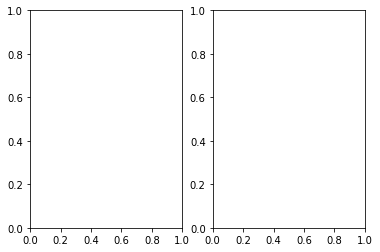

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob


path = "/content/drive/MyDrive/train/"

img_list = sorted(glob.glob(path+'data/*/*/*.jpg'))
mask_list = sorted(glob.glob(path+'mask/*/*/*.png'))
row_size =320
col_size = 320

x_data, y_data = np.empty((2, len(img_list), row_size, col_size , 1), dtype=np.float32)

print(len(mask_list))
print(len(img_list))
for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(row_size, col_size , 1), preserve_range=True)
    x_data[i] = img
      
for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(row_size, col_size , 1), preserve_range=True)
    y_data[i] = img
    
y_data /= 255.

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].imshow(y_data[12].squeeze(), cmap='gray')


x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1,shuffle=True)

np.save(path+'x_train.npy', x_train)
np.save(path+'y_train.npy', y_train)
np.save(path+'x_val.npy', x_val)
np.save(path+'y_val.npy', y_val)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

##U-net Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, concatenate, Dropout, Conv2D, Conv3D
from keras.layers import MaxPooling2D, MaxPooling3D, Conv2DTranspose, UpSampling2D
from keras.layers import BatchNormalization, Activation
from keras.layers import Reshape, Dense, multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import keras.utils
from keras import backend as K
from keras import models
from keras import callbacks
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

path = "/content/drive/MyDrive/train/"

x_train = np.load(path+'x_train.npy')
y_train = np.load(path+'y_train.npy')
x_val = np.load(path+'x_val.npy')
y_val = np.load(path+'y_val.npy')
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


inputs = Input(shape=(320, 320,1 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
batch1 = BatchNormalization()(conv1) 
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(batch1)
drop1 = tf.keras.layers.Dropout(0.1)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)


conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
batch2 = BatchNormalization()(conv2) 
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(batch2)
drop2 = tf.keras.layers.Dropout(0.1)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)


conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
batch3 = BatchNormalization()(conv3) 
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(batch3)
drop3 = tf.keras.layers.Dropout(0.1)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
batch4 = BatchNormalization()(conv4) 
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(batch4)
drop4 = tf.keras.layers.Dropout(0.1)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
batch5 = BatchNormalization()(conv5) 
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch5)
drop5 = tf.keras.layers.Dropout(0.1)(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2),padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
batch6 = BatchNormalization()(conv6) 
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(batch6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2),
                                       padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
batch7 = BatchNormalization()(conv7) 
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(batch7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2),
                                       padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
batch8 = BatchNormalization()(conv8) 
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(batch8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2),
                                       padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
batch9 = BatchNormalization()(conv9) 
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(batch9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)

history = model.fit(x_train, y_train, batch_size=16, epochs=20,
                        verbose=1, shuffle=True,
                        validation_data=(x_val, y_val),callbacks=[model_checkpoint])

model.summary()
model.save(path+"Unet")

##Video to Numpy and Prediction

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import sys
import glob
from google.colab.patches import cv2_imshow
import scipy.misc
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
model_path = "/content/drive/MyDrive/train/"
model = keras.models.load_model(model_path+"Unet", compile =False)

path = "/content/drive/MyDrive/nystagmus/Rt_Lat_canal/34/"
def video_to_tensor():
  cap = cv2.VideoCapture(path+"bl.avi")
  tensor = []
  while cap.isOpened():
      ret, image = cap.read()

      if not ret:
          break
      image = resize(image,output_shape= (320, 320,1),preserve_range=True)
      gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      tensor.append(np.asarray(gray_img))
      cv2.waitKey(0)

  tensor = np.array(tensor)
  cv2.destroyAllWindows()
  cap.release()
  return tensor

# img_list = sorted(glob.glob(path+'8_hrl,180/*.jpg'))
# row_size =320
# col_size = 320
# x_data = np.empty((len(img_list), row_size, col_size , 1), dtype=np.float32)

# print(len(x_data))
# for i, img_path in enumerate(img_list):
#     img = imread(img_path)
#     img = resize(img, output_shape=(row_size, col_size , 1), preserve_range=True)
#     x_data[i] = img

#x_test = np.asarray(np.load(path+"x_train.npy"),dtype="uint8")
#preds = np.asarray(np.load(path+"y_train.npy"),dtype="uint8")
x_test = np.asarray(video_to_tensor())
preds = np.asarray(model.predict(x_test))

img_rows =320
img_cols =320
def set_view():
    total=x_test.shape[0]
    img = np.ndarray((total, img_rows, img_cols), dtype=np.uint8)
    mask = np.ndarray((total, img_rows, img_cols), dtype=np.uint8)
    kernel = np.ones((5, 5), np.uint8)
    dst = np.full((total,img_rows, img_cols),255,dtype=np.uint8)
    img = x_test
    mask = preds
    print("total time : {0:0.2f}".format(total/30))
    for m in range(total):
        msk = cv2.dilate(mask[m], kernel, iterations=1)
        msk = cv2.GaussianBlur(msk, (0,0), 7)
        cv2.copyTo(img[m],msk,dst[m])
    return dst

view_imgs = np.ndarray((x_test.shape[0],img_rows, img_cols), dtype=np.uint8)
view_imgs = set_view()
for i in range(20):
    cv2_imshow(x_test[i,:,:])
    cv2_imshow(view_imgs[i,:,:])

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
path = "/content/drive/MyDrive/retinal/"
model = keras.models.load_model(path+"Unet", compile =False)

msk = np.asarray(cv2.imread(path+"Train_Mask/1.png",cv2.IMREAD_GRAYSCALE),dtype="uint8")
img = cv2.imread(path+"Train_img/1.jpg",cv2.IMREAD_GRAYSCALE)
x = np.ones((120,320),dtype="uint8")*255
cv2_imshow(img)

cv2.copyTo(img,msk,x)
cv2_imshow(x)


#Nystagmus Detection 

##Setting

In [ ]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from skimage.io import imread
import os, glob
import keras
from keras import optimizers
from keras.models import Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from skimage.transform import resize
import shutil

path = "/content/drive/MyDrive/bppv/"
bppv_path = "/content/drive/MyDrive/nystagmus/"
model_save_path = "/content/drive/MyDrive/"

approval_range = 6 # The parameter of How many checks to judge nystagmus 
segment_range = 5 # Interval to Slicing video 
img_height,  img_width =120,320
suffix = ".avi"
#video_list = sorted(glob.glob(path+'/*/*'+suffix))


classes = [os.path.basename(x) for x in glob.glob(path+"/*") if x not in glob.glob(path+"/*.*")]
#behavior_class = list(set([os.path.basename(x) for x in glob.glob(bppv_path+"*/*/*4.avi")]))
behavior_class = list(set([os.path.basename(x) for x in glob.glob(bppv_path+"/*/*/*.avi")]))
output_class = [os.path.basename(x) for x in glob.glob(bppv_path+"/*") if x not in glob.glob(bppv_path+"/*.*")]

print("nystagmus class is : ",end="")
print(classes)

print("behavior class is : ",end="")
print(behavior_class)

print("output class is : ",end="")
print(output_class)


nystagmus class is : ['left_nystagmus', 'normal', 'right_nystagmus']
behavior class is : ['blb-자발안진 Rt beating있으나 bowing test할때안진작아지고 leaning tets할때안진커짐).avi', 'blbl.avi', 'ld (2).avi', 'hrr,180.avi', 'ld.avi', 'hrr (2).avi', 'hrl.avi', 'hrl,r.avi', 'hrr,l,r.avi', 'hrl,180 (2).avi', 'hrl 180.avi', 'bl.avi', 'hrr.avi', 'hrl,180.avi']
output class is : ['Lt_Lat_canal', 'Rt_Lat_canal']


##Make DataSet To Numpy
 * processing for Convlstm Input

In [ ]:
[os.remove(f) for f in glob.glob(path+"/.DS_Store")]
[os.remove(f) for f in glob.glob(path+"/*/.DS_Store")]
[os.remove(f) for f in glob.glob(path+'x_train.npy')]
[os.remove(f) for f in glob.glob(path+'y_train.npy')]
[os.remove(f) for f in glob.glob(path+'x_val.npy')]
[os.remove(f) for f in glob.glob(path+'y_val.npy')]

def frames_extraction_and_create(video_path):
    frames_list = []
    X = []
    Y = np.zeros((len(glob.glob(path+"*/*/")),len(classes)),dtype = int)
    print(Y.shape)
    for c in classes: #nystagmus, runout
        files_list = os.listdir(os.path.join(path,c))
        for files in files_list: # 45,46,51....
          file_img = os.listdir(os.path.join(path,c+"/"+files))
          for segment in file_img: #334.jpg 335.jpg
              if segment.find("jpg") != -1:
                  image = cv2.imread(os.path.join(path,c+"/"+files+"/"+segment))
                  image = resize(image, output_shape=(img_height,  img_width))
                  frames_list.append(np.uint8(image*255))
          X.append(frames_list)
          frames_list = []
          Y[len(X)-1,classes.index(c)]=1
    Y=np.asarray(Y)
    X=np.asarray(X)
    return X,Y

X,Y=frames_extraction_and_create(path)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3,shuffle=True)

np.save(path+'x_train.npy', x_train)
np.save(path+'y_train.npy', y_train)
np.save(path+'x_val.npy', x_val)
np.save(path+'y_val.npy', y_val)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(375, 3)


##Classifier Model

In [ ]:
def load_data(path):
  x_train = np.load(path+'x_train.npy',allow_pickle=True)
  y_train = np.load(path+'y_train.npy',allow_pickle=True)
  x_test = np.load(path+'x_val.npy',allow_pickle=True)
  y_test = np.load(path+'y_val.npy',allow_pickle=True)
  print("Data load is done...")
  return x_train,x_test,y_train,y_test

def get_Model():
  inp = keras.layers.Input(shape=(15,120,320,3))

  x = keras.layers.Conv3D(filters=64,kernel_size=(9,9,9),activation="tanh")(inp)
  x = keras.layers.MaxPooling3D(pool_size = (3,9,9),padding ='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Conv3D(filters=64,kernel_size=(7, 7,7),activation="tanh")(inp)
  x = keras.layers.MaxPooling3D(pool_size = (2,7,7),padding ='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Conv3D(filters=64,kernel_size=(5, 5,5),activation="tanh")(inp)
  x = keras.layers.MaxPooling3D(pool_size = (1,5,5),padding ='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Conv3D(filters=64,kernel_size=(3, 3,3),activation="tanh")(x)
  x = keras.layers.MaxPooling3D(pool_size = (1,3,3),padding ='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Conv3D(filters=64,kernel_size=(1, 1,1),activation="tanh")(x)
  x = keras.layers.MaxPooling3D(pool_size = (1,1,1),padding ='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(1024,activation = "relu")(x)
  x = keras.layers.Dense(256,activation = "relu")(x)
  x = keras.layers.Dense(len(classes),activation = "softmax")(x)

  model = keras.models.Model(inp, x)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0000005)
  model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
  model.summary()
  #model.save(model_save_path+"Classifier")
  #model.save("Classifier_model.h5")
  return model

model = get_Model()
x_train, x_test, y_train, y_test = load_data(path)

earlystop = EarlyStopping(patience=7)
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=5)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path+"Classifier",
                                                 save_weights_only=True,
                                                 verbose=0)
# Define modifiable training hyperparameters.
epochs = 20
batch_size = 6

# Fit the model to the training data.
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr,cp_callback],
    validation_data=(x_test, y_test)
)

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 120, 320, 3)  0         
                             ]                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 11, 116, 316, 64)  24064     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 11, 24, 64, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 11, 24, 64, 64)   256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 11, 24, 64, 64)    0         
                                                             

FileNotFoundError: ignored

## Make Context Vector and Image Restoration

*   Image_Slicer 
*   Image_Restoration
*   make_context_vector


 

In [ ]:
from numpy.core.numeric import zeros_like
[shutil.rmtree(f) for f in glob.glob(bppv_path+'/*/*/pred')]

def Img_Slicer(video):
  # original video tensor [N,120,320,3]
  tensor = [] 
  cap = cv2.VideoCapture(video)
  if cap.isOpened():
    while True:
      ret, img_color = cap.read()
      if ret:
          img = resize(img_color, output_shape=(img_height,  img_width))
          tensor.append(np.uint8(img*255))
      else:
          break
  else:
      print("파일읽기 불가능")
  tensor = np.array(tensor)
  sliced_img =[]
  index = 0

  # ex) (1000,120,320,3) => 1000/5(segment_range)=> 200-(15/5)-1 = 198 => (198,15,120,320,3)
  loop = (len(tensor)/segment_range)-int(15/segment_range)-1
  for i in range(int(loop)):
  # segment_range = 5 => [[0~15],[5,20],[10,25]...]
      sliced_img.append(tensor[(index*segment_range):(index*segment_range)+15]) 
      index=index+1

  sliced_img = np.array(sliced_img)
  return sliced_img # output => (N,15,120,320,3)

def Image_Restoration(video_path,data_tensor,pred):
  print("Make Video....")
  idx = 0
  if os.path.isdir(os.path.dirname(video_path)+"/pred")==False:
    os.mkdir(os.path.dirname(video_path)+"/pred")
  pred = np.asarray(model.predict(data_tensor),dtype=np.float32)
  fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
  #ex) nystagmus/Lt.Lat.canal/1/pred/bl_output.avi
  out = cv2.VideoWriter(os.path.dirname(video_path)+"/pred/"+os.path.basename(video_path).replace(suffix,"")+'_output.avi', fourcc, 30.0, (img_width,img_height))
  print("savename : "+os.path.basename(video_path).replace(suffix,"")+'_output.avi')
  print("======================================")
  for data in data_tensor:
    for i in range(0,segment_range):
  #(N,15,120,320,3) => [0,5][6,10][11,15]... => restoration(N,120,320,3)
        cv2.putText(data[i],classes[pred[idx].argmax()],(10,20),cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,255,255),1)
        out.write(data[i])
    idx=idx+1

  out.release()
  cv2.destroyAllWindows()

def make_context_vector(model,video_list,approval_range):
  # initialize
  behavior_dict={}
  for c in behavior_class:
    behavior_dict[c] = -1
  patient_behavior_dict={}

  # make Sliced Video (N,15,320,120,3)
  for video in video_list:
    print("video name : "+os.path.basename(video))
    preds = np.asarray(model.predict(Img_Slicer(video)),dtype=np.float32)
    #Image_Restoration(video,Img_Slicer(video),preds)
    patient_behavior_dict[os.path.basename(video)]=preds
  #{bl.avi:[[0.5,0,5],[0.7,0.3]....](Prediction in 15segment)}

  lst = [0 for x in range(len(classes))] #[0,0,0]
  for key in patient_behavior_dict.keys(): #[rt_nystagmus, normal, lt_nystagmus]
    for i in range(len(patient_behavior_dict[key])-approval_range):
      store=[patient_behavior_dict[key][x].argmax() for x in range(i,i+approval_range-1)]
      if store.count(patient_behavior_dict[key][i].argmax()) == approval_range-1 and patient_behavior_dict[key][i].argmax() != classes.index("normal"):
          lst[patient_behavior_dict[key][i].argmax()] = 1
          behavior_dict[key.replace(path,"")] = lst
    lst = [0 for x in range(len(classes))]
  
  print(behavior_dict)
  context_vector = list(behavior_dict.values())
  return context_vector # ex) [[0,1,1,0],[0,0,1,0].[1,0,0,0],[-1,-1,-1,-1]]

print(classes)
ctv = make_context_vector(model,glob.glob(bppv_path+"*/*/bl.avi"),4)

['left_nystagmus', 'normal', 'right_nystagmus']
video name : hrl 180.avi
video name : ld.avi
video name : hrl,180 (2).avi
video name : bl.avi
video name : hrr.avi
video name : ld.avi
video name : bl.avi
video name : hrl.avi
video name : hrl,180.avi
video name : hrr.avi
video name : hrr (2).avi
video name : hrl,180.avi
video name : hrr.avi
video name : ld.avi
video name : hrl,180.avi
video name : hrr.avi
video name : ld.avi
video name : hrl,180.avi
video name : hrr.avi
video name : bl.avi
video name : hrl 180.avi


ResourceExhaustedError: ignored

In [ ]:
def context_vector_Labeler(path):
    #bppv_class = filter(os.path.isdir,glob.glob(path+"/*"))#["Left_LC_BPPV","LeftAC_BPPV","LeftPC_BPPV","Right_LC_BPPV","Right_AC_BPPV","Right_PC_BPPV"]
    bppv_class = [os.path.basename(x) for x in glob.glob(bppv_path+"/*") if x not in glob.glob(path+"/*.*")]
    Y = np.zeros((len(glob.glob(path+"/*/*")),len(bppv_class)),dtype = int) #(N,6) dim. ex) bppv(path) -> lat_canal_bppv -> 1,2,3 -> video
    print(bppv_class)
    X = []
    class_folder =glob.glob(path+"/*") #ex) bppv(path) -> lat_canal_bppv...(class_folder) -> 1,2,3 -> video
    for bppv in class_folder:
        video_folder = glob.glob(bppv+"/*") #ex) bppv(path) -> ../lat_canal_bppv...(class_folder) -> 1,2,3 (video_folder)-> video
        class_folder_base = os.path.basename(bppv) # lat_canal_bppv, ... [mov,fix] -> class_folder_base = fix
        for video in video_folder: #1,2,3,4,5.... N num of video_folder
          X.append(make_context_vector(model,glob.glob(video+"/*.MOV"))) #bl.avi, hrr.avi...  => [0,1,1,0] make shape of context vector
          Y[len(X)-1,bppv_class.index(class_folder_base)]=1
          
    X = np.array(X)
    Y = np.array(Y)
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3,shuffle=True)
    np.save(path+'x_train_context.npy', x_train)
    np.save(path+'y_train_context.npy', y_train)
    np.save(path+'x_val_context.npy', x_val)
    np.save(path+'y_val_context.npy', y_val)

def load_context_data(path):
  x_train = np.load(path+'x_train_context.npy',allow_pickle=True)
  y_train = np.load(path+'y_train_context.npy',allow_pickle=True)
  x_test = np.load(path+'x_val_context.npy',allow_pickle=True)
  y_test = np.load(path+'y_val_context.npy',allow_pickle=True)
  print("Data load is done...")
  return x_train,x_test,y_train,y_test

def Get_BPPV_Classifier_Model(context_vector):
    inp = keras.layers.Input(shape=(np.shape(context_vector)))
    x = keras.layers.Dense(1024,activation = "relu")(inp)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(256,activation = "relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(len(output_class),activation = "softmax")(x)
    model = keras.models.Model(inp, x)

    opt = tf.keras.optimizers.Adam(learning_rate=0.0000005)
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
    model.summary()
    #model.save(path+"BPPV_Classifier")
    return model

context_vector_Labeler(bppv_path)
x_train, x_test, y_train, y_test = load_context_data(bppv_path) #->지정
print(x_train[0].shape)
bppv_model = Get_BPPV_Classifier_Model(x_train[0]) 

earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 8

# Fit the model to the training data.
history = bppv_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    validation_data=(x_test, y_test)
)

test_loss, test_acc = bppv_model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
a = [0 for i in range(4)]
a = np.array(a)
print(a[0:3].all() == 0)

True
